In [1]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.1 MB/s eta 0:00:00


In [2]:
import torch
import triton
import triton.language as tl

In [3]:
@triton.jit
def matmul_kernel(
    a_ptr,
    b_ptr,
    c_ptr,
    M,
    N,
    K,
    stride_am,
    stride_ak,
    stride_bk,
    stride_bn,
    stride_cm,
    stride_cn,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)

In [4]:
def matmul(a, b, BSM, BSN, BSK, GSM):
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (
        triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),
    )
    matmul_kernel[grid](
        a,
        b,
        c,
        M,
        N,
        K,
        a.stride(0),
        a.stride(1),
        b.stride(0),
        b.stride(1),
        c.stride(0),
        c.stride(1),
        BSM,
        BSN,
        BSK,
        GSM,
    )
    return c

In [9]:
configs = [
    triton.testing.Benchmark(
        x_names=["K"],
        x_vals=[i for i in range(512, 8193, 512)],
        line_arg="provider",
        line_vals=["cublas", "triton"],
        line_names=["cuBLAS", "Triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="Time (ms)",
        plot_name=f"matmul-performance-fp16-{BSM}-{BSN}-{BSK}-{GSM}",
        args={
            "M": 8192,
            "N": 8192,
            "BSM": BSM,
            "BSN": BSN,
            "BSK": BSK,
            "GSM": GSM,
        },
    )
    for BSM in [64, 128]
    for BSN in [64, 128]
    for BSK in [64, 128]
    for GSM in [4, 8, 16]
]


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, BSM, BSN, BSK, GSM):
    a = torch.randn((M, K), device="cuda", dtype=torch.float16)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16)
    if provider == "cublas":
        ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b)
        )
    if provider == "triton":
        ms = triton.testing.do_bench(
            lambda: matmul(a, b, BSM, BSN, BSK, GSM)
        )

    return ms

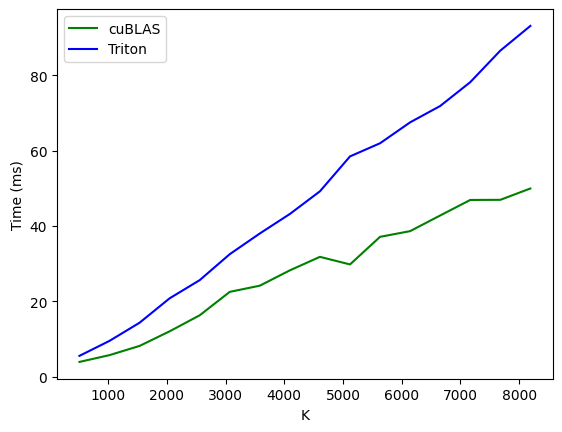

matmul-performance-fp16-64-64-64-4:
         K     cuBLAS     Triton
0    512.0   3.939700   5.550970
1   1024.0   5.745659   9.528605
2   1536.0   8.187786  14.342906
3   2048.0  12.066702  20.823902
4   2560.0  16.314459  25.648682
5   3072.0  22.537086  32.538834
6   3584.0  24.178604  38.036865
7   4096.0  28.250380  43.217552
8   4608.0  31.831350  49.229824
9   5120.0  29.819082  58.493599
10  5632.0  37.143520  61.986847
11  6144.0  38.657520  67.535362
12  6656.0  42.811695  71.875008
13  7168.0  46.933407  78.198814
14  7680.0  46.967632  86.569244
15  8192.0  49.978622  93.132095


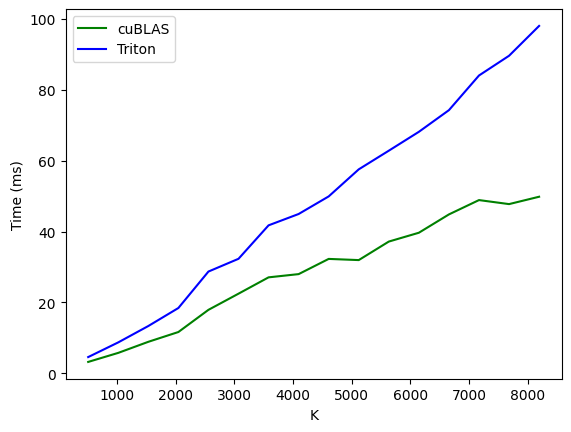

matmul-performance-fp16-64-64-64-8:
         K     cuBLAS     Triton
0    512.0   3.218272   4.585917
1   1024.0   5.770957   8.729099
2   1536.0   8.891729  13.345520
3   2048.0  11.652372  18.424456
4   2560.0  17.907534  28.707296
5   3072.0  22.467113  32.304127
6   3584.0  27.072983  41.740017
7   4096.0  27.982498  44.939041
8   4608.0  32.272720  49.901409
9   5120.0  31.940414  57.534431
10  5632.0  37.162800  62.797825
11  6144.0  39.653633  68.118530
12  6656.0  44.822975  74.229759
13  7168.0  48.865345  84.003555
14  7680.0  47.731297  89.569283
15  8192.0  49.809505  97.988190


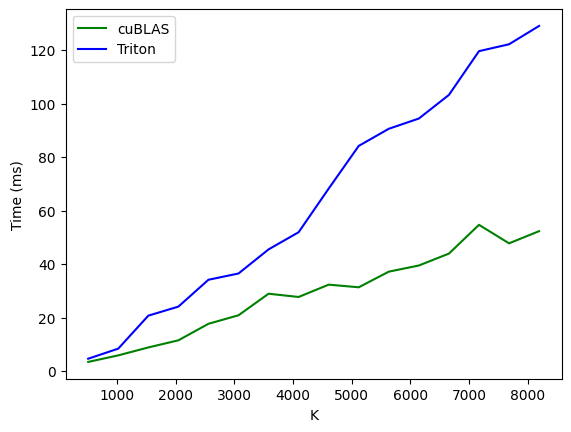

matmul-performance-fp16-64-64-64-16:
         K     cuBLAS      Triton
0    512.0   3.415380    4.612735
1   1024.0   5.862500    8.381581
2   1536.0   8.826845   20.706272
3   2048.0  11.489799   24.089144
4   2560.0  17.666208   34.125519
5   3072.0  20.852272   36.467407
6   3584.0  28.904449   45.472801
7   4096.0  27.691084   51.897953
8   4608.0  32.299328   68.202560
9   5120.0  31.310015   84.159714
10  5632.0  37.157681   90.560738
11  6144.0  39.454254   94.391357
12  6656.0  43.907837  103.217056
13  7168.0  54.657120  119.572479
14  7680.0  47.746033  122.149887
15  8192.0  52.291775  129.004456


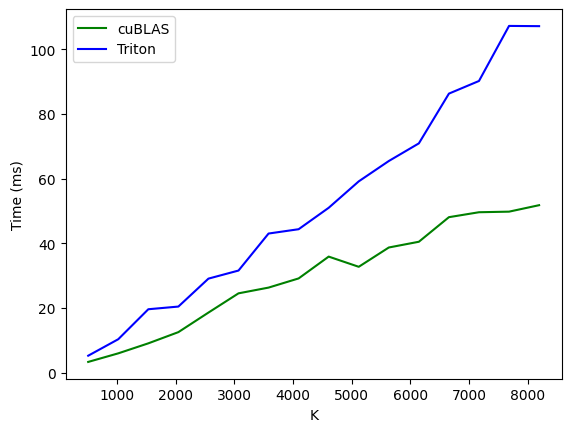

matmul-performance-fp16-64-64-128-4:
         K     cuBLAS      Triton
0    512.0   3.327227    5.248428
1   1024.0   5.979279   10.344048
2   1536.0   9.072817   19.612545
3   2048.0  12.537473   20.441336
4   2560.0  18.582150   29.078049
5   3072.0  24.529676   31.575914
6   3584.0  26.304949   43.016609
7   4096.0  29.141068   44.352783
8   4608.0  35.886097   50.976768
9   5120.0  32.735855   59.147072
10  5632.0  38.701790   65.438110
11  6144.0  40.477951   70.892548
12  6656.0  48.076481   86.276093
13  7168.0  49.602783   90.181633
14  7680.0  49.782818  107.202141
15  8192.0  51.781822  107.130852


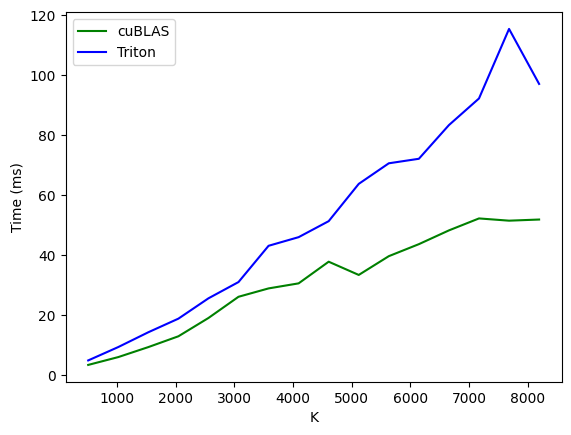

matmul-performance-fp16-64-64-128-8:
         K     cuBLAS      Triton
0    512.0   3.524806    5.023751
1   1024.0   6.135522    9.480244
2   1536.0   9.466732   14.411380
3   2048.0  13.065335   18.942017
4   2560.0  19.162745   25.719200
5   3072.0  26.234198   31.140724
6   3584.0  29.023031   43.222015
7   4096.0  30.704865   46.102562
8   4608.0  37.923203   51.433502
9   5120.0  33.512383   63.856670
10  5632.0  39.766479   70.717789
11  6144.0  43.768913   72.222847
12  6656.0  48.357422   83.449760
13  7168.0  52.344833   92.321632
14  7680.0  51.597088  115.499008
15  8192.0  51.977985   97.168831


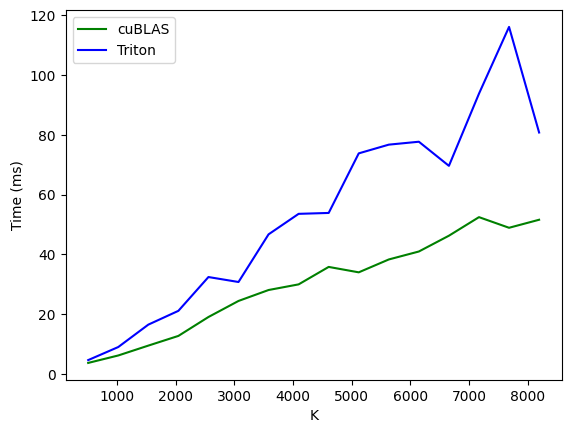

matmul-performance-fp16-64-64-128-16:
         K     cuBLAS      Triton
0    512.0   3.729729    4.677458
1   1024.0   6.222455    9.043380
2   1536.0   9.520947   16.538742
3   2048.0  12.763844   21.149200
4   2560.0  19.088251   32.458359
5   3072.0  24.459284   30.797400
6   3584.0  28.117109   46.739197
7   4096.0  30.004425   53.596287
8   4608.0  35.843170   53.898655
9   5120.0  34.030289   73.824707
10  5632.0  38.337536   76.742813
11  6144.0  41.000912   77.718430
12  6656.0  46.283661   69.650398
13  7168.0  52.492321   93.800354
14  7680.0  48.935169  116.120674
15  8192.0  51.620384   80.799683


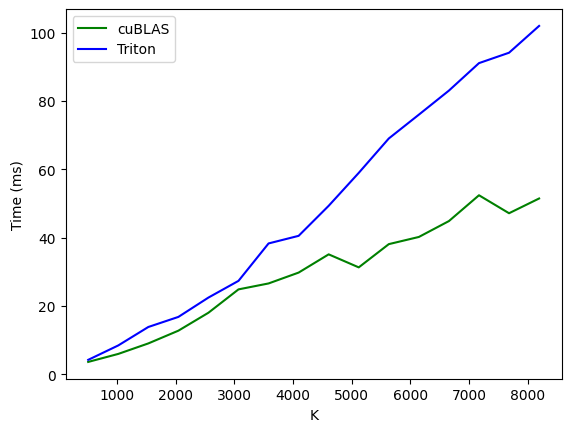

matmul-performance-fp16-64-128-64-4:
         K     cuBLAS      Triton
0    512.0   3.604371    4.207328
1   1024.0   5.947016    8.428532
2   1536.0   9.018833   13.828044
3   2048.0  12.748325   16.777599
4   2560.0  18.002399   22.440184
5   3072.0  24.835669   27.330582
6   3584.0  26.573088   38.280369
7   4096.0  29.750111   40.505325
8   4608.0  35.087440   49.299358
9   5120.0  31.277824   58.933697
10  5632.0  38.078384   69.001122
11  6144.0  40.178383   75.975937
12  6656.0  44.828449   83.019615
13  7168.0  52.381695   91.056290
14  7680.0  47.121902   94.100258
15  8192.0  51.438431  101.944862


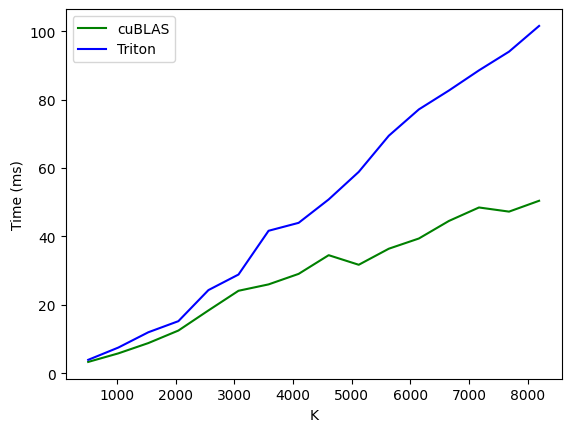

matmul-performance-fp16-64-128-64-8:
         K     cuBLAS      Triton
0    512.0   3.322518    3.930117
1   1024.0   5.815664    7.512759
2   1536.0   8.831699   11.995519
3   2048.0  12.496385   15.238894
4   2560.0  18.377697   24.327305
5   3072.0  24.128071   28.877281
6   3584.0  25.992758   41.670418
7   4096.0  29.066462   43.989906
8   4608.0  34.535072   50.835106
9   5120.0  31.730433   58.894367
10  5632.0  36.425152   69.461983
11  6144.0  39.412174   77.161758
12  6656.0  44.547169   82.688004
13  7168.0  48.482910   88.581917
14  7680.0  47.273056   94.054558
15  8192.0  50.446335  101.572960


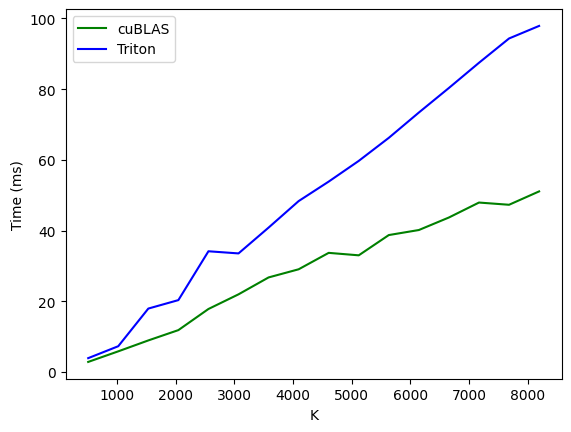

matmul-performance-fp16-64-128-64-16:
         K     cuBLAS     Triton
0    512.0   2.848090   3.915420
1   1024.0   5.842743   7.289523
2   1536.0   8.928562  17.938198
3   2048.0  11.844979  20.331305
4   2560.0  17.818861  34.144108
5   3072.0  21.962944  33.536545
6   3584.0  26.742369  40.833633
7   4096.0  29.046442  48.332767
8   4608.0  33.693008  53.848450
9   5120.0  32.997715  59.705376
10  5632.0  38.728493  66.226402
11  6144.0  40.153809  73.385536
12  6656.0  43.698017  80.336899
13  7168.0  47.923008  87.454529
14  7680.0  47.294735  94.329536
15  8192.0  51.077122  97.878914


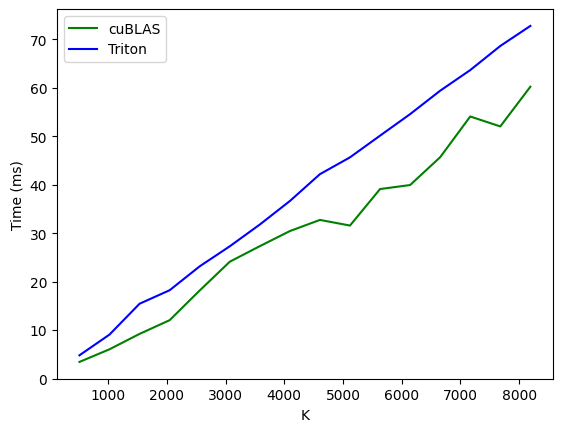

matmul-performance-fp16-64-128-128-4:
         K     cuBLAS     Triton
0    512.0   3.436977   4.802365
1   1024.0   6.044590   9.080736
2   1536.0   9.222735  15.446229
3   2048.0  12.049700  18.231199
4   2560.0  18.176218  23.163614
5   3072.0  24.110680  27.294657
6   3584.0  27.325895  31.789551
7   4096.0  30.442352  36.642239
8   4608.0  32.740929  42.183632
9   5120.0  31.579920  45.655457
10  5632.0  39.111969  50.130047
11  6144.0  39.939522  54.573441
12  6656.0  45.684494  59.405888
13  7168.0  54.085632  63.662079
14  7680.0  52.034527  68.638176
15  8192.0  60.227585  72.775230


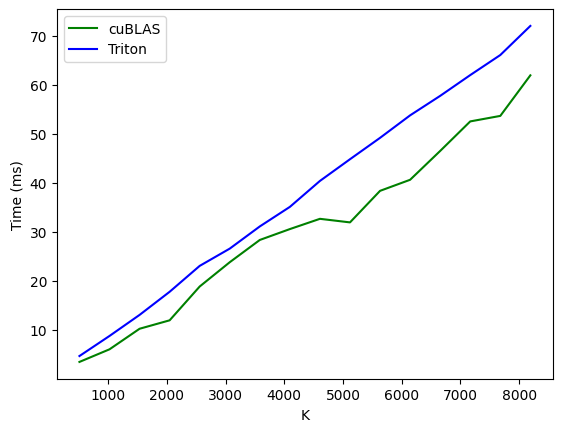

matmul-performance-fp16-64-128-128-8:
         K     cuBLAS     Triton
0    512.0   3.518843   4.718740
1   1024.0   6.087508   8.810848
2   1536.0  10.276843  13.097862
3   2048.0  11.994553  17.807663
4   2560.0  18.883480  23.086517
5   3072.0  23.832808  26.603531
6   3584.0  28.368811  31.125696
7   4096.0  30.584982  35.107807
8   4608.0  32.674175  40.394463
9   5120.0  31.946850  44.815186
10  5632.0  38.374367  49.173439
11  6144.0  40.629089  53.756096
12  6656.0  46.504333  57.726143
13  7168.0  52.520226  61.958145
14  7680.0  53.643341  66.044540
15  8192.0  61.908993  71.975517


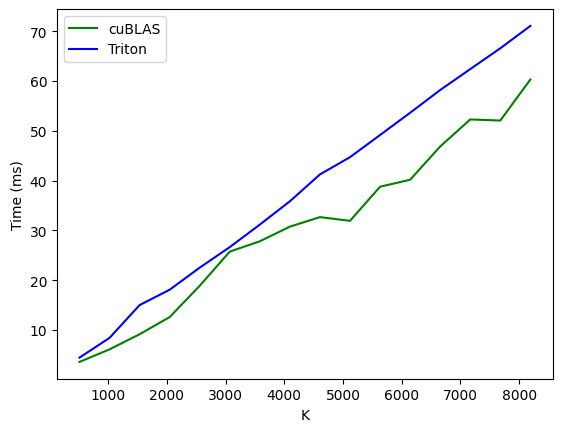

matmul-performance-fp16-64-128-128-16:
         K     cuBLAS     Triton
0    512.0   3.591425   4.452165
1   1024.0   6.110933   8.411428
2   1536.0   9.149194  15.003098
3   2048.0  12.591981  18.089752
4   2560.0  18.878151  22.525743
5   3072.0  25.747744  26.650995
6   3584.0  27.826645  31.173616
7   4096.0  30.761812  35.856529
8   4608.0  32.680882  41.255486
9   5120.0  31.930305  44.719040
10  5632.0  38.780289  49.168289
11  6144.0  40.185440  53.638081
12  6656.0  46.870209  58.212097
13  7168.0  52.299393  62.410751
14  7680.0  52.076546  66.594879
15  8192.0  60.319168  71.085732


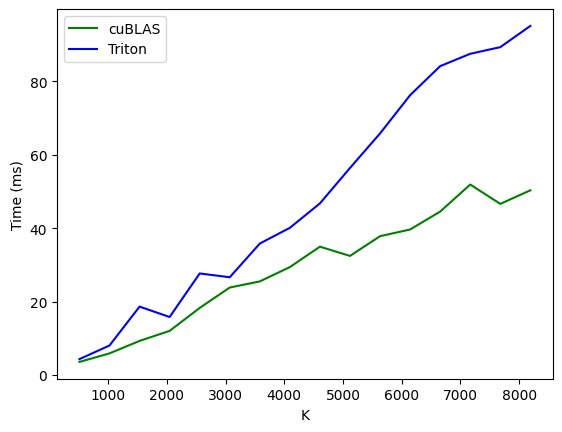

matmul-performance-fp16-128-64-64-4:
         K     cuBLAS     Triton
0    512.0   3.580948   4.341416
1   1024.0   5.908299   8.052256
2   1536.0   9.304863  18.644663
3   2048.0  12.034465  15.811358
4   2560.0  18.285517  27.672703
5   3072.0  23.839041  26.635595
6   3584.0  25.500982  35.809937
7   4096.0  29.410080  40.098846
8   4608.0  34.962959  46.747807
9   5120.0  32.442379  56.396961
10  5632.0  37.820129  65.799011
11  6144.0  39.644081  76.214050
12  6656.0  44.515968  84.123871
13  7168.0  51.886082  87.489983
14  7680.0  46.612785  89.294754
15  8192.0  50.308414  95.073853


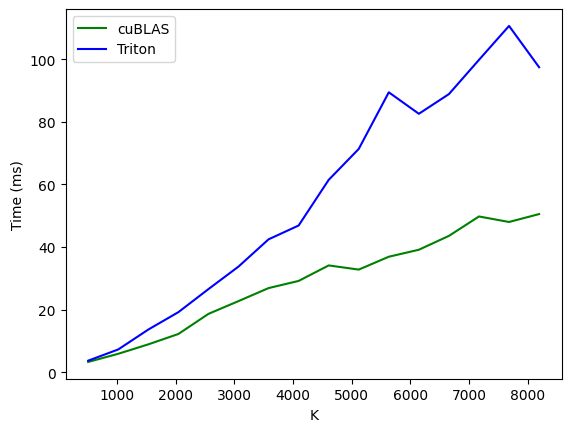

matmul-performance-fp16-128-64-64-8:
         K     cuBLAS      Triton
0    512.0   3.345063    3.745319
1   1024.0   5.942986    7.330429
2   1536.0   8.954679   13.682541
3   2048.0  12.266985   19.234257
4   2560.0  18.683666   26.597313
5   3072.0  22.762585   33.786785
6   3584.0  26.919252   42.486656
7   4096.0  29.202890   46.897423
8   4608.0  34.155823   61.472706
9   5120.0  32.824223   71.352097
10  5632.0  36.928032   89.429726
11  6144.0  39.163551   82.573761
12  6656.0  43.589680   88.857796
13  7168.0  49.783409   99.792862
14  7680.0  48.028770  110.624733
15  8192.0  50.551296   97.428413


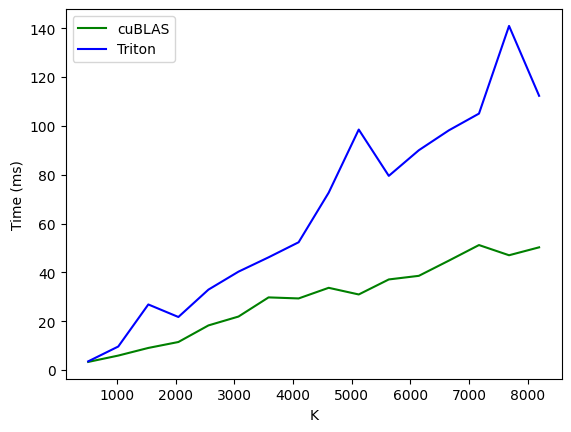

matmul-performance-fp16-128-64-64-16:
         K     cuBLAS      Triton
0    512.0   3.338838    3.565632
1   1024.0   5.936246    9.642298
2   1536.0   9.063334   26.866142
3   2048.0  11.492604   21.735271
4   2560.0  18.285925   32.939575
5   3072.0  21.916306   40.300209
6   3584.0  29.758974   46.163967
7   4096.0  29.331627   52.334049
8   4608.0  33.680992   72.636452
9   5120.0  30.958475   98.475998
10  5632.0  37.108833   79.518051
11  6144.0  38.590637   90.018372
12  6656.0  44.823887   98.172928
13  7168.0  51.189728  105.012733
14  7680.0  47.015377  140.909149
15  8192.0  50.255871  112.295456


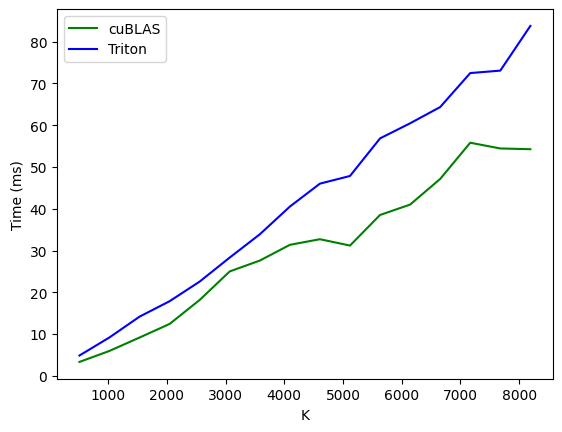

matmul-performance-fp16-128-64-128-4:
         K     cuBLAS     Triton
0    512.0   3.332219   4.864410
1   1024.0   5.970610   9.200872
2   1536.0   9.170548  14.176112
3   2048.0  12.427057  17.868368
4   2560.0  18.172695  22.570452
5   3072.0  25.001591  28.323221
6   3584.0  27.595840  33.884941
7   4096.0  31.363392  40.520672
8   4608.0  32.707935  46.012863
9   5120.0  31.188208  47.845459
10  5632.0  38.512527  56.846046
11  6144.0  40.996063  60.456928
12  6656.0  47.137794  64.347900
13  7168.0  55.804897  72.481506
14  7680.0  54.431744  73.067810
15  8192.0  54.257729  83.767296


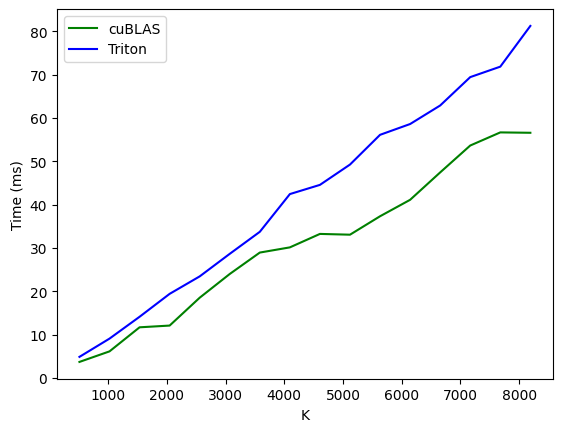

matmul-performance-fp16-128-64-128-8:
         K     cuBLAS     Triton
0    512.0   3.716964   4.882978
1   1024.0   6.151390   9.096204
2   1536.0  11.705484  14.135589
3   2048.0  12.106153  19.426159
4   2560.0  18.536448  23.458206
5   3072.0  24.014160  28.665461
6   3584.0  28.955690  33.745918
7   4096.0  30.154184  42.454048
8   4608.0  33.259296  44.577438
9   5120.0  33.080849  49.267487
10  5632.0  37.335342  56.129440
11  6144.0  41.130669  58.621696
12  6656.0  47.455441  62.900223
13  7168.0  53.659775  69.447746
14  7680.0  56.688736  71.862946
15  8192.0  56.601791  81.262589


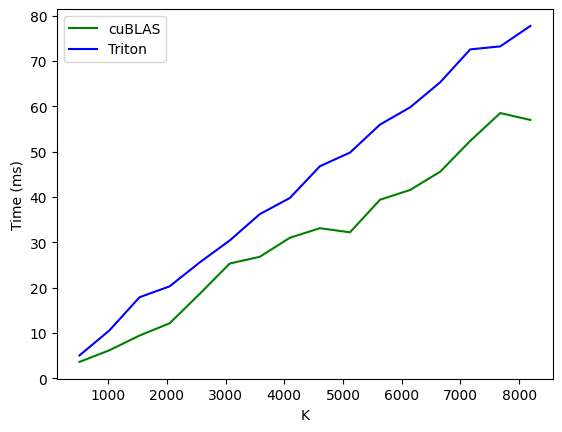

matmul-performance-fp16-128-64-128-16:
         K     cuBLAS     Triton
0    512.0   3.576903   4.999744
1   1024.0   6.158514  10.557029
2   1536.0   9.403910  17.863987
3   2048.0  12.105165  20.265039
4   2560.0  18.600737  25.544043
5   3072.0  25.301062  30.396353
6   3584.0  26.787476  36.212769
7   4096.0  30.991056  39.778305
8   4608.0  33.100769  46.789696
9   5120.0  32.193279  49.798882
10  5632.0  39.393280  55.987873
11  6144.0  41.550961  59.784927
12  6656.0  45.573040  65.319969
13  7168.0  52.387871  72.585052
14  7680.0  58.525330  73.248772
15  8192.0  57.004318  77.764061


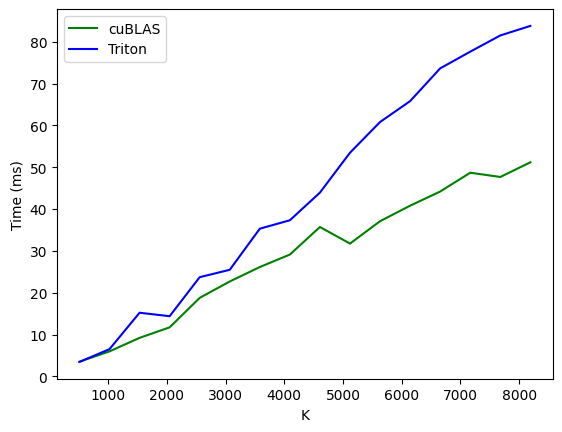

matmul-performance-fp16-128-128-64-4:
         K     cuBLAS     Triton
0    512.0   3.529577   3.471570
1   1024.0   5.990276   6.528679
2   1536.0   9.223787  15.221840
3   2048.0  11.731624  14.396955
4   2560.0  18.777145  23.722561
5   3072.0  22.691788  25.484022
6   3584.0  26.146173  35.307281
7   4096.0  29.128983  37.322739
8   4608.0  35.712242  43.931923
9   5120.0  31.749598  53.460831
10  5632.0  37.098465  60.798241
11  6144.0  40.805389  65.795166
12  6656.0  44.190849  73.617058
13  7168.0  48.681599  77.604836
14  7680.0  47.669556  81.483772
15  8192.0  51.169502  83.760735


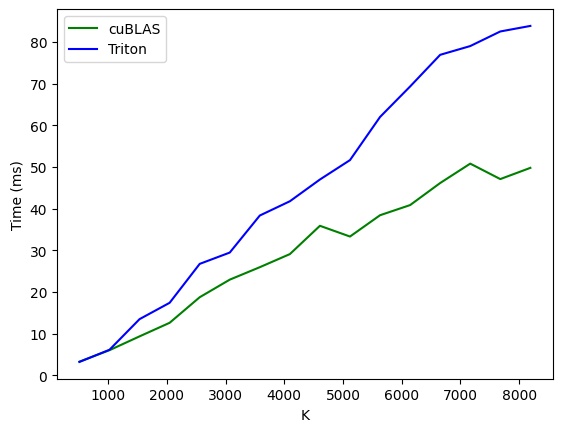

matmul-performance-fp16-128-128-64-8:
         K     cuBLAS     Triton
0    512.0   3.319459   3.253935
1   1024.0   6.069565   6.173392
2   1536.0   9.385873  13.519172
3   2048.0  12.636498  17.436222
4   2560.0  18.772160  26.771751
5   3072.0  22.988457  29.485077
6   3584.0  25.979456  38.374432
7   4096.0  29.119062  41.794594
8   4608.0  35.907280  47.013119
9   5120.0  33.331417  51.666943
10  5632.0  38.443665  62.017536
11  6144.0  40.877377  69.328896
12  6656.0  46.168434  76.922562
13  7168.0  50.821217  79.021980
14  7680.0  47.115105  82.524323
15  8192.0  49.804863  83.853699


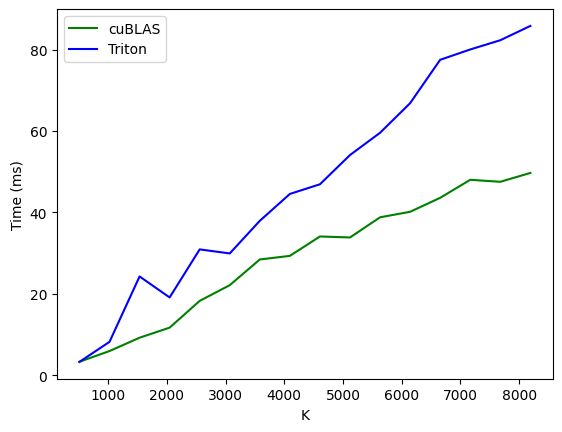

matmul-performance-fp16-128-128-64-16:
         K     cuBLAS     Triton
0    512.0   3.346328   3.303206
1   1024.0   5.974758   8.234345
2   1536.0   9.246353  24.286669
3   2048.0  11.720027  19.134815
4   2560.0  18.290668  30.936043
5   3072.0  22.149632  29.940500
6   3584.0  28.456329  37.953632
7   4096.0  29.345612  44.551758
8   4608.0  34.109600  46.920883
9   5120.0  33.864223  54.099838
10  5632.0  38.813713  59.568127
11  6144.0  40.167633  66.833054
12  6656.0  43.598305  77.487808
13  7168.0  48.023266  80.020416
14  7680.0  47.531342  82.292831
15  8192.0  49.707935  85.805244


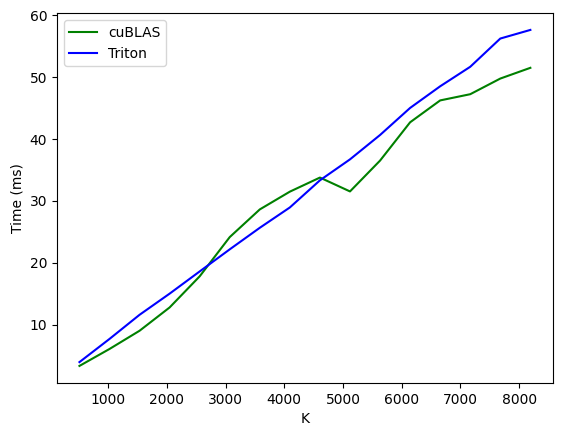

matmul-performance-fp16-128-128-128-4:
         K     cuBLAS     Triton
0    512.0   3.300241   3.917537
1   1024.0   6.042363   7.666361
2   1536.0   8.989605  11.571671
3   2048.0  12.761102  14.993036
4   2560.0  17.795649  18.586073
5   3072.0  24.143368  22.160032
6   3584.0  28.618517  25.647318
7   4096.0  31.492704  28.937141
8   4608.0  33.769871  33.325165
9   5120.0  31.526543  36.714031
10  5632.0  36.515182  40.655968
11  6144.0  42.711342  45.034431
12  6656.0  46.250366  48.535614
13  7168.0  47.254688  51.690559
14  7680.0  49.785473  56.258270
15  8192.0  51.522015  57.653248


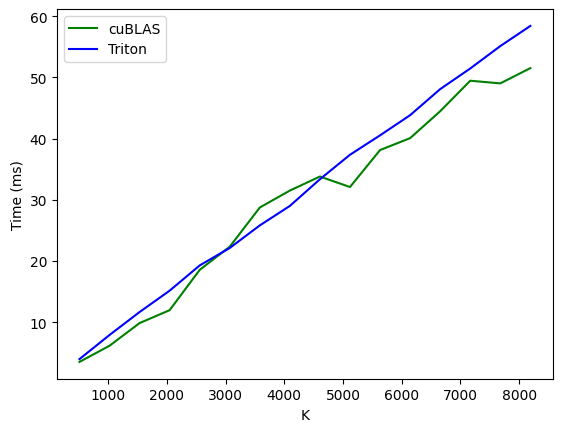

matmul-performance-fp16-128-128-128-8:
         K     cuBLAS     Triton
0    512.0   3.509376   3.965673
1   1024.0   6.151259   7.907165
2   1536.0   9.857615  11.660965
3   2048.0  11.965775  15.151987
4   2560.0  18.551983  19.274632
5   3072.0  22.336767  22.130144
6   3584.0  28.743591  25.817087
7   4096.0  31.511862  29.002357
8   4608.0  33.803185  33.360626
9   5120.0  32.087746  37.361122
10  5632.0  38.129841  40.532368
11  6144.0  40.075714  43.827728
12  6656.0  44.473022  48.085182
13  7168.0  49.457024  51.459713
14  7680.0  49.024929  55.119362
15  8192.0  51.516865  58.413025


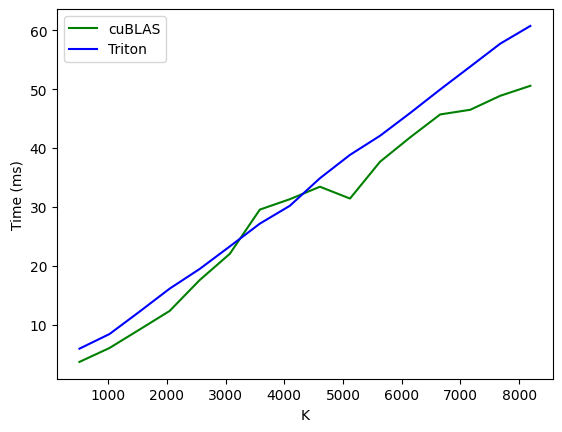

matmul-performance-fp16-128-128-128-16:
         K     cuBLAS     Triton
0    512.0   3.664462   5.915483
1   1024.0   6.030151   8.402976
2   1536.0   9.165619  12.210613
3   2048.0  12.326344  16.111412
4   2560.0  17.568678  19.459496
5   3072.0  22.021751  23.278891
6   3584.0  29.539597  27.153738
7   4096.0  31.311935  30.193098
8   4608.0  33.428993  34.869888
9   5120.0  31.418415  38.839584
10  5632.0  37.673889  42.085762
11  6144.0  41.807888  45.946175
12  6656.0  45.708130  49.947426
13  7168.0  46.501823  53.832958
14  7680.0  48.879181  57.737247
15  8192.0  50.571297  60.745728


In [10]:
benchmark.run(print_data=True, show_plots=True)